In [1]:
test = [True, 3, False]

import torch 

# Create a tensor from a list
x = torch.tensor(test)
x

tensor([1, 3, 0])

In [1]:
# load pickle file 

import pickle

path = "resources/data/cifar-100-python/meta"
with open(path, 'rb') as f:
    pickle_data = pickle.load(f)

print(pickle_data)

{'fine_label_names': ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'w

In [6]:
# get index of 'boy', sunflowers, apples, couch, bee, lion, plain, turtle, hamster, pine

fine_label_names = pickle_data['fine_label_names']

words_to_find = ['boy', 'sunflower', 'apple', 'couch', 'bee', 'lion', 'plain', 'turtle', 'hamster', 'pine_tree']

for word in words_to_find:
    print(f"Index of {word}: {fine_label_names.index(word)}")

Index of boy: 11
Index of sunflower: 82
Index of apple: 0
Index of couch: 25
Index of bee: 6
Index of lion: 43
Index of plain: 60
Index of turtle: 93
Index of hamster: 36
Index of pine_tree: 59


In [2]:
# import resnet 
from torchvision import models
resnet18 = models.resnet18()

# import cifar-100 dataset
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

path = "resources/data/cifar-100-python/train"

with open(path, 'rb') as f:
    cifar100 = pickle.load(f, encoding='bytes')

print(cifar100.keys())

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [3]:
# load cifar100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR100(root='resources/data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = datasets.CIFAR100(root='resources/data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
retain_samples = []
forget_samples = []
for elem in trainset: 
    if elem[1] == 11:
        forget_samples.append(elem)
    else:
        retain_samples.append(elem)

len(retain_samples), len(forget_samples)

(49500, 500)

In [20]:
def cifar100_fine_to_coarse_idx(fine_idx):
    # Mapping from fine labels (0-99) to coarse labels (0-19) based on CIFAR-100 dataset
    fine_to_coarse = [
        4, 1, 14, 8, 0, 6, 7, 7, 18, 3,
        3, 14, 9, 18, 7, 11, 3, 9, 7, 11,
        6, 11, 5, 10, 7, 6, 13, 15, 3, 15,
        0, 11, 1, 10, 12, 14, 16, 9, 11, 5,
        5, 19, 8, 8, 15, 13, 14, 17, 18, 10,
        16, 4, 17, 4, 2, 0, 17, 4, 18, 17,
        10, 3, 2, 12, 12, 16, 12, 1, 9, 19,
        2, 10, 0, 1, 16, 12, 9, 13, 15, 13,
        16, 19, 2, 4, 6, 19, 5, 5, 8, 19,
        18, 1, 2, 15, 6, 0, 17, 8, 14, 13
    ]
    
    return fine_to_coarse[fine_idx]

# Example usage:
fine_label_idx = 23  # Example fine label index
coarse_label_idx = cifar100_fine_to_coarse_idx(fine_label_idx)
print(f"Fine label {fine_label_idx} maps to coarse label {coarse_label_idx}")


Fine label 23 maps to coarse label 10


In [21]:
# create two datasets for retain and forget samples
class Cifar100Dataset:
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx][0]
        y = cifar100_fine_to_coarse_idx(self.samples[idx][1])
        return x, y

retain_dataset = Cifar100Dataset(retain_samples)
forget_dataset = Cifar100Dataset(forget_samples)

retain_loader = DataLoader(retain_dataset, batch_size=4, shuffle=True, num_workers=2)
forget_loader = DataLoader(forget_dataset, batch_size=4, shuffle=True, num_workers=2)

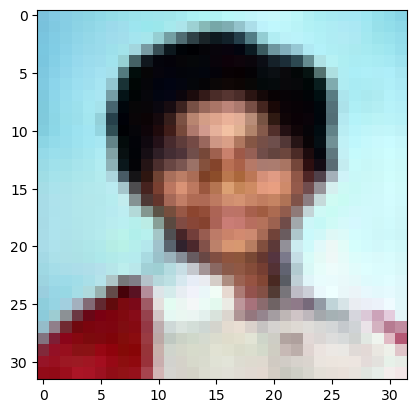

14


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(forget_dataset[0][0])
print(forget_dataset[0][1])

In [32]:
# resnet model 
import torch
import torch.nn as nn

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, 20)
resnet18 = resnet18.to(device)

# training loop
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for i, data in enumerate(retain_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = resnet18(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}")
            running_loss = 0.0


  0%|          | 0/10 [00:00<?, ?it/s]

[1, 2000] loss: 3.128727398633957
[1, 4000] loss: 2.932221142888069
[1, 6000] loss: 2.856457120299339
[1, 8000] loss: 2.7815883888602255
[1, 10000] loss: 2.7486641197800634
[1, 12000] loss: 2.690902258455753


 10%|█         | 1/10 [01:07<10:07, 67.47s/it]

[2, 2000] loss: 2.6559421448111533
[2, 4000] loss: 2.600999473512173
[2, 6000] loss: 2.6108056002259254
[2, 8000] loss: 2.577447236597538
[2, 10000] loss: 2.547904668688774
[2, 12000] loss: 2.4875091831684113


 20%|██        | 2/10 [02:15<09:00, 67.62s/it]

[3, 2000] loss: 2.4756713929176333
[3, 4000] loss: 2.4607428320050238
[3, 6000] loss: 2.4492944948971274
[3, 8000] loss: 2.488922216922045
[3, 10000] loss: 2.41555493915081
[3, 12000] loss: 2.3923105643093585


 30%|███       | 3/10 [03:22<07:52, 67.56s/it]

[4, 2000] loss: 2.3813351278603077
[4, 4000] loss: 2.3581950688064097
[4, 6000] loss: 2.33333945402503
[4, 8000] loss: 2.323099815040827
[4, 10000] loss: 2.3453977248370648
[4, 12000] loss: 2.3230413064062594


 40%|████      | 4/10 [04:29<06:44, 67.44s/it]

[5, 2000] loss: 2.277423752337694
[5, 4000] loss: 2.290108485370874
[5, 6000] loss: 2.3049702451229095
[5, 8000] loss: 2.2645976515114308
[5, 10000] loss: 2.282638212516904
[5, 12000] loss: 2.280507592201233


 50%|█████     | 5/10 [05:37<05:36, 67.35s/it]

[6, 2000] loss: 2.2506475942730906
[6, 4000] loss: 2.216782793074846
[6, 6000] loss: 2.21381825363636
[6, 8000] loss: 2.221113764345646
[6, 10000] loss: 2.1875127732455732
[6, 12000] loss: 2.2398967609107494


 60%|██████    | 6/10 [06:44<04:29, 67.39s/it]

[7, 2000] loss: 2.167808995515108
[7, 4000] loss: 2.1777832366228105
[7, 6000] loss: 2.1531347993910313
[7, 8000] loss: 2.1567942351847886
[7, 10000] loss: 2.133683716788888
[7, 12000] loss: 2.13585650023818


 70%|███████   | 7/10 [07:51<03:22, 67.35s/it]

[8, 2000] loss: 2.1005378238260746
[8, 4000] loss: 2.0782370700091124
[8, 6000] loss: 2.0891153584122657
[8, 8000] loss: 2.082530228808522
[8, 10000] loss: 2.058455073803663
[8, 12000] loss: 2.0838522815555334


 80%|████████  | 8/10 [08:58<02:14, 67.26s/it]

[9, 2000] loss: 2.05818202316761
[9, 4000] loss: 2.015151668712497
[9, 6000] loss: 2.0446454443633555
[9, 8000] loss: 2.037137091577053
[9, 10000] loss: 2.047531548127532
[9, 12000] loss: 2.0267791188657283


 90%|█████████ | 9/10 [10:06<01:07, 67.33s/it]

[10, 2000] loss: 2.006545876774937
[10, 4000] loss: 1.97996480306983
[10, 6000] loss: 2.0024342493116856
[10, 8000] loss: 1.9637828556746244
[10, 10000] loss: 1.9756978620290757
[10, 12000] loss: 2.0203721135109665


100%|██████████| 10/10 [11:13<00:00, 67.40s/it]


In [35]:
# test on the forget set 

correct = 0
total = 0
with torch.no_grad():
    for data in forget_loader:
        images, labels = data
        outputs = resnet18(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f"Accuracy on forget set: {100 * correct / total}%")

Accuracy on forget set: 11.6%
